# CNN+LSTM

## load data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def load_and_preprocess(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # 删除包含 NaN 的行
    train_df = train_df.dropna()
    test_df = test_df.dropna()

    # 将 'time' 列转换为 datetime 格式并设置为索引
    train_df['time'] = pd.to_datetime(train_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
    train_df.set_index('time', inplace=True)

    test_df['time'] = pd.to_datetime(test_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
    test_df.set_index('time', inplace=True)

    # 提取特征和标签
    X_train = train_df.drop(columns=['attack'])
    y_train = train_df['attack']

    X_test = test_df.drop(columns=['attack'])
    y_test = test_df['attack']

    # 标准化特征
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape for CNN: (batch_size, channels, height, width)
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_and_preprocess('../data/merged_table_attack_2_withtag_processed.csv', '../data/merged_table_attack_1_withtag_processed.csv')


## difine model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1))
        )
        self.lstm = nn.LSTM(32, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = self.cnn(x)
        x = x.squeeze(3).permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
num_classes = 2
model = CNNLSTMClassifier(input_size, hidden_size, num_layers, num_classes)


## train

In [7]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
batch_size = 64

def train_model(model, X_train, y_train, num_epochs, batch_size):
    model.train()
    for epoch in range(num_epochs):
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size].to(device)
            y_batch = y_train[i:i+batch_size].to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train_model(model, X_train, y_train, num_epochs, batch_size)


Epoch [10/50], Loss: 1.1310
Epoch [20/50], Loss: 1.0689
Epoch [30/50], Loss: 0.9551
Epoch [40/50], Loss: 1.4035
Epoch [50/50], Loss: 1.0404


## evaluate

c:\Users\ROG\miniconda3\envs\dl\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG\miniconda3\envs\dl\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG\miniconda3\envs\dl\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


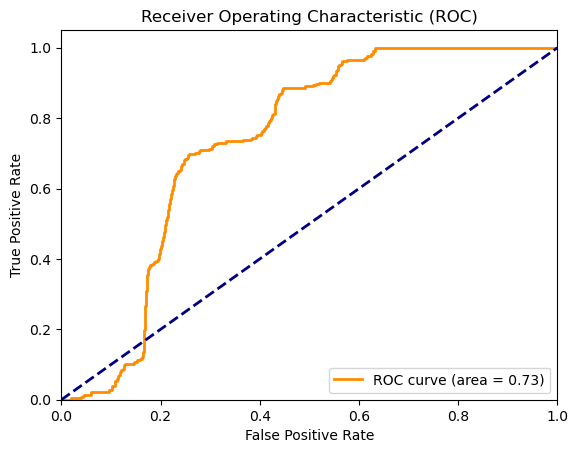

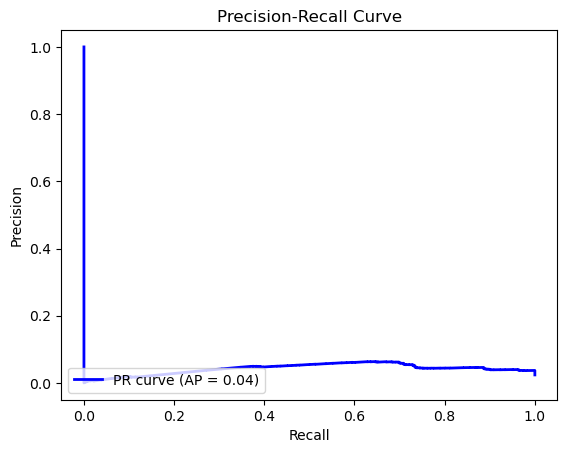

CNN+LSTM Accuracy: 0.9761763960462955
CNN+LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11555
           1       0.00      0.00      0.00       282

    accuracy                           0.98     11837
   macro avg       0.49      0.50      0.49     11837
weighted avg       0.95      0.98      0.96     11837



In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, classification_report

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)

        accuracy = accuracy_score(y_test.cpu(), predicted.cpu())
        report = classification_report(y_test.cpu(), predicted.cpu())

        y_prob = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        fpr, tpr, _ = roc_curve(y_test.cpu(), y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()

        precision, recall, _ = precision_recall_curve(y_test.cpu(), y_prob)
        average_precision = average_precision_score(y_test.cpu(), y_prob)

        plt.figure()
        plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()

        print(f"CNN+LSTM Accuracy: {accuracy}")
        print("CNN+LSTM Classification Report:")
        print(report)

evaluate_model(model, X_test, y_test)